# Estimate the Moho for South America

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [2]:
from __future__ import division
import cPickle as pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

The computations generate a lot of run-time warnings. They aren't anything to be concerned about so disable them to avoid clutter.

In [3]:
import warnings
warnings.simplefilter('ignore')

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [4]:
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando

In [5]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


Load our custom classes and functions.

In [6]:
from tesseroid_mesh import TesseroidRelief
from datasets import fetch_assumpcao_moho_points, down_sample
from moho import MohoGravityInvSpherical, cross_validation, make_mesh

Get the number of cores in this computer to run the some things in parallel.

In [7]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 8


## Load the gravity data

Load the data that was processed in [`south-america-gravity-data.ipynb`](south-america-gravity-data.ipynb).

In [8]:
with open('../data/processed-goco5s-data-sam-h50km.txt') as f:
    _ = f.readline()
    line = f.readline()
    shape = [int(x) for x in line.split()[1:]]
    lat, lon, height, data = np.loadtxt(f, usecols=[0, 1, 2, -1], unpack=True)

In [9]:
print('Number of data points in lat and lon: {}'.format(shape))

Number of data points in lat and lon: [81, 61]


In [10]:
area = (lat.min(), lat.max(), lon.min(), lon.max())
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='l')

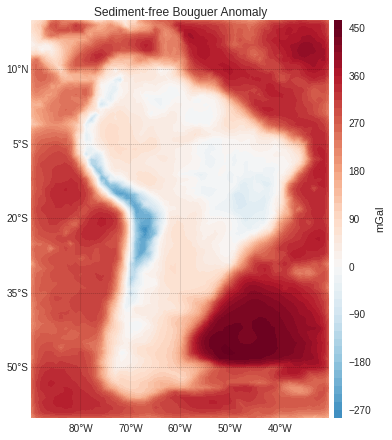

In [11]:
x, y = bm(lon, lat)
ranges = np.abs([data.min(), data.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Sediment-free Bouguer Anomaly')
bm.contourf(x, y, data, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

## Load the cross-validation data

Load the test dataset (10 km height anomaly). This is used for cross-validation to find the regularization parameter.

In [12]:
test_set = np.loadtxt('../data/processed-goco5s-data-sam-h10km.txt', usecols=[0, 1, 2, -1], unpack=True)

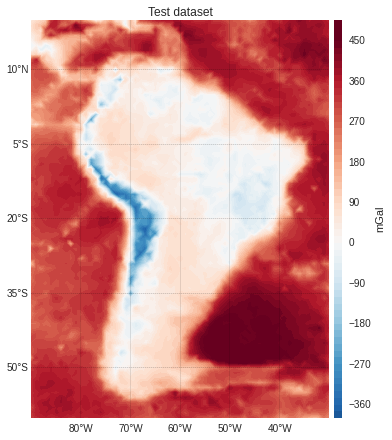

In [13]:
x, y = bm(test_set[1], test_set[0])
ranges = np.abs([data.min(), data.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Test dataset')
bm.contourf(x, y, test_set[-1], 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

Load the point seismic constraints. This is used in cross-validation to find the reference level and the density contrast.

In [14]:
test_points = fetch_assumpcao_moho_points('../data/Moho_Map_SAm2013_data.tar.gz', todepth=True, return_height=False)[:-1]

In [15]:
test_points[1] += 360

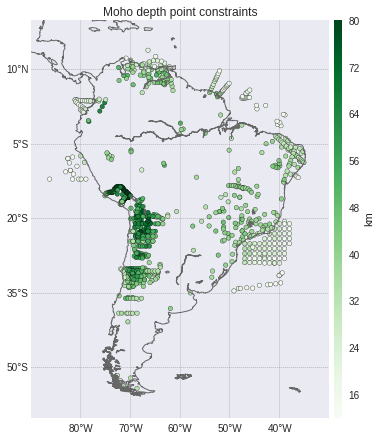

In [16]:
x, y = bm(test_points[1], test_points[0])

plt.figure(figsize=(7, 6))
plt.title('Moho depth point constraints')
bm.scatter(x, y, c=-0.001*test_points[-1], s=20, cmap='Greens')
plt.colorbar(pad=0.01, aspect=50).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
bm.drawcoastlines(color="#666666")
plt.tight_layout()

## Define plotting functions

In [17]:
def plot_fit(lat, lon, data, solution, bm):    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 6))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, data, shape, 40, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, solution[0].predicted(), shape, levels, 
                basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_residuals(solution):
    residuals = solution[0].residuals()
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_estimate(solution, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Estimated Moho depth")
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic(solution, test_points, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    diff = -0.001*seismic_residuals(moho, *test_points)
    ranges = np.abs([diff.max(), diff.min()]).max()
    lat, lon, depth = test_points
    xp, yp = bm(lon, lat)
   
    fig = plt.figure(figsize=(7, 6))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01, aspect=50).set_label('Estimated Moho depth (km)')
    bm.scatter(xp, yp, c=diff, s=40, cmap='PuOr_r', 
                     vmin=-ranges, vmax=ranges, linewidths=0.1)
    cb = plt.colorbar(pad=0.01, aspect=50)
    cb.set_label('Difference between estimated and seismic (km)')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 1, 0], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic_hist(solution, test_points):
    moho = solution.estimate_
    diff = -0.001*seismic_residuals(moho, *test_points)

    plt.figure(figsize=(3, 2.5))
    plt.title('Difference (seismic points)')
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(diff.mean(), diff.std()), 
             transform=plt.gca().transAxes)
    # Use the line above so the text coordinates are in axes coordinates (0 to 1)
    # instead of data coordinates, which may vary between runs.
    plt.hist(diff, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Differences (km)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)

In [18]:
def plot_cv_regul(regul_params, scores, best, log=True): 
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (regularization parameter)')
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)
    
def plot_cv_ref_dens(densities, referece_levels, scores, best_dens, best_ref):
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (reference level and density)')
    plt.contourf(densities, -0.001*reference_levels, scores, 30, cmap='BuPu_r')
    plt.colorbar(pad=0.01).set_label('Mean Square Error')
    plt.plot(densities[best_dens], -0.001*referece_levels[best_ref], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    l = plt.legend(loc='upper left')
    for txt in l.get_texts():
        txt.set_color('#ffffff')
    plt.xlabel(u'Density contrast (kg/m³)')
    plt.ylabel('Reference level (km)')
    plt.tight_layout(pad=0)
    
def plot_convergence(solution, log=True):
    plt.figure(figsize=(5, 3))
    plt.title('Convergence')
    plt.plot(range(solution.stats_['iterations'] + 1), solution.stats_['objective'])
    plt.xlabel('Iteration')
    plt.ylabel('Goal function')
    if log:
        plt.yscale('log')
    plt.tight_layout(pad=0)


## Define cross-validation functions

In [19]:
def score_test_set(model, lat, lon, height, data, njobs=1):
    predicted = tesseroid.gz(lon, lat, height, model, njobs=njobs)
    score = np.sum((predicted - data)**2)/data.size
    return score

In [20]:
def seismic_residuals(moho, lat, lon, height):
    # moho is the estimated TesseroidRelief object given by
    # solver.estimate_. lat lon and height are the point constraints
    estimated = gridder.interp_at(moho.clat.ravel(), moho.clon.ravel(), moho.relief, 
                                  lat, lon, extrapolate=True)
    return estimated - height
    
def score_seismic_constraints(moho, lat, lon, height):
    residuals = seismic_residuals(moho, lat, lon, height)
    rms = np.sum(residuals**2)/height.size
    return rms

In [21]:
def cross_validation_regul(misfit, regul, regul_params, config, test_set, njobs=1): 
    args = dict(misfit=misfit, regul=regul, config=config, test_set=test_set)
    # Put all the arguments need to for each inversion run into 
    # dictionaries. Each element of the list is the configuration
    # for run.
    args = [dict(regul_param=mu, misfit=misfit, regul=regul, config=config, test_set=test_set) 
            for mu in regul_params]
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        results = pool.map(fit_score_regul, args)
        pool.close()
        pool.join()
    else:
        results = map(fit_score_regul, args)
    scores, solutions = zip(*results)
    best = np.nanargmin(scores)
    solution = solutions[best]
    return dict(best=best, solution=solution, scores=scores, solutions=solutions)

def fit_score_regul(args):
    # Need to unpack the configuration for this run
    # from the dictionary. This is because multiprocessing.Pool.map
    # only allows me to pass a single argument to the function.
    misfit = args['misfit']
    regul = args['regul']
    config = args['config']
    test_set = args['test_set']
    mu = args['regul_param']
    # The try...except block is catch any error that might
    # occur. This stops the whole cross-validation process from
    # shutting down because of an error. The solution is marked
    # as None so that we know there is a problem.
    try:
        solution = (misfit + mu*regul).config(**config).fit().copy()
        score = score_test_set(solution.estimate_, *test_set)
    except:
        solution = None
        score = np.nan
    return score, solution   

In [22]:
def cross_validation_ref_dens(solver, densities, reference_levels, test_points, njobs=1): 
    # Put all the arguments need to for each inversion run into 
    # dictionaries. Each element of the list is the configuration
    # for run. Columns are density, rows are reference level.
    cvmatrix = [[dict(density=dens, reference=ref, solver=solver, test_points=test_points) 
                 for dens in densities]
                for ref in reference_levels]
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        # itertools.chain flattens the cvmatrix
        results = pool.map(fit_score_ref_dens, itertools.chain(*cvmatrix))
        pool.close()
        pool.join()
    else:
        results = map(fit_score_ref_dens, itertools.chain(*cvmatrix))
    scores, solutions = zip(*results)
    # Transforms the list of solutions into 2D arrays
    shape = (len(reference_levels), len(densities))
    solutions = zip(*[iter(solutions)]*len(densities))
    scores = np.array(scores).reshape(shape)
    best_ref, best_dens = np.unravel_index(np.nanargmin(scores), scores.shape)
    solution = solutions[best_ref][best_dens]    
    return dict(best_ref=best_ref, best_dens=best_dens, solution=solution, scores=scores, solutions=solutions)

def fit_score_ref_dens(args):
    # Need to unpack the configuration for this run
    # from the dictionary. This is because multiprocessing.Pool.map
    # only allows me to pass a single argument to the function.
    solver = args['solver']
    test_points = args['test_points']    
    # Configure the solver to use the specified density
    # and reference level
    solver[0].set_density(args['density']).set_reference(args['reference'])
    # The try...except block is catch any error that might
    # occur. This stops the whole cross-validation process from
    # shutting down because of an error. The solution is marked
    # as None so that we know there is a problem.
    try:
        solution = solver.fit().copy()
        score = score_seismic_constraints(solution.estimate_, *test_points)
    except:
        solution = None
        score = np.nan
    return score, solution

## Inversion setup

In [23]:
mesh = make_mesh(area, shape)

In [24]:
initial = -60e3*np.ones(mesh.size)  # The initial estimate doesn't really matter too much
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
config = dict(method='newton', initial=initial, tol=0.2, maxit=6)
regul = Smoothness2D(mesh.shape)

In [41]:
regul_params = np.logspace(-10, -4, 8)
regul_params

array([  1.00000000e-10,   7.19685673e-10,   5.17947468e-09,
         3.72759372e-08,   2.68269580e-07,   1.93069773e-06,
         1.38949549e-05,   1.00000000e-04])

In [42]:
reference_levels = np.arange(-35e3, -20e3 + 1, 5000)
reference_levels

array([-35000., -30000., -25000., -20000.])

In [43]:
densities = np.arange(200, 500 + 1, 100)
densities

array([200, 300, 400, 500])

## Inversion

In [36]:
misfit.set_density(densities[0]).set_reference(reference_levels[0])

In [37]:
%time cvregul = cross_validation_regul(misfit, regul, regul_params, config, test_set, njobs=ncpu)

CPU times: user 232 ms, sys: 80 ms, total: 312 ms
Wall time: 5min 19s


(50.0, 3000.0)

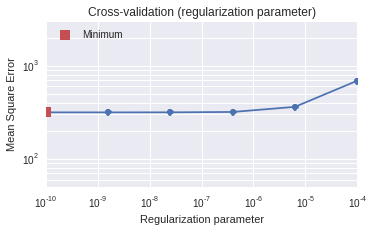

In [38]:
plot_cv_regul(regul_params, cvregul['scores'], cvregul['best'], log=True)
plt.grid(True, which='both', axis='y')
plt.ylim(5e1, 3e3)

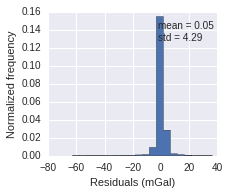

In [39]:
plot_residuals(cvregul['solution'])

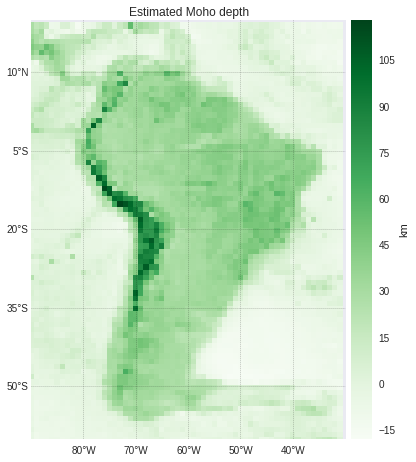

In [40]:
plot_estimate(cvregul['solution'], bm)

In [ ]:
%time cvrefdens = cross_validation_ref_dens(cvregul['solution'], densities, reference_levels, test_points, njobs=ncpu)

Save the results to a Python pickle file to use later without having to re-compute (in case we need to come back and work on the plots).

In [ ]:
with open('south-america-moho.pickle', 'w') as f:
    pickle.dump([cvregul, cvrefdens], f)

In [ ]:
#with open('synthetic-crust1-south-america.pickle') as f:
#    res_regul, res_refdens = pickle.load(f)

In [ ]:
solution = cvrefdens['solution']
best_dens = cvrefdens['best_dens']
best_ref = cvrefdens['best_ref']

In [ ]:
print('Cross-validation results:')
print(u'  reference level: {} km (true = {})'.format(-0.001*reference_levels[best_ref], -0.001*reference))
print(u'  density contrast: {} kg/m³ (true = {})'.format(densities[best_dens], moho_density_contrast))
print(u'  regularization parameter: {}'.format(regul_params[cvregul['best']]))

In [ ]:
plot_cv_ref_dens(densities, reference_levels, cvrefdens['scores'], best_dens, best_ref)

In [ ]:
plot_fit(lat, lon, data, solution, bm)

In [ ]:
plot_residuals(solution)

In [ ]:
plot_estimate(solution, bm)

In [ ]:
plot_diff_seismic(solution, test_points, bm)

In [44]:
plot_diff_seismic_hist(solution, test_points)

NameError: name 'solution' is not defined

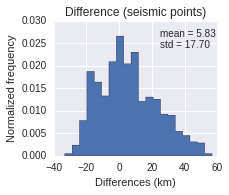

In [45]:
plot_diff_seismic_hist(cvregul['solution'], test_points)

[]()